In [1]:
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras import Input, Model

from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

# __Set Parmeters__

In [2]:
n_epochs=30
n_batch_size=34
size= 200
# True to use less number of samples during the training trials, False to obtain final trained model using all samples.
developing_stage=True 

# __Reading and exploring data__

In [3]:
!pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d jangedoo/utkface-new

100% 331M/331M [00:10<00:00, 41.6MB/s]
100% 331M/331M [00:10<00:00, 33.0MB/s]


In [4]:
!unzip -qq /content/utkface-new.zip

In [5]:
images = []
ages = []
genders = []
if developing_stage:
    last_idx=5000   
else:
    last_idx=-1

for i in os.listdir('/content/UTKFace')[:last_idx]:
    split = i.split('_')
    ages.append(int(split[0]))
    genders.append(int(split[1]))
    images.append(Image.open('/content/UTKFace/'+i))

In [6]:
images = pd.Series(list(images), name = 'Images')
ages = pd.Series(list(ages), name = 'Ages')
genders = pd.Series(list(genders), name = 'Genders')

df = pd.concat([images, ages, genders], axis=1)
df.head()

,Images,Ages,Genders
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,1,0
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,35,0
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,90,0
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,62,0
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,65,0


In [7]:
def get_gender(x):
    return "Female" if x else "Male"

Age and Gender :  18 ,  Male


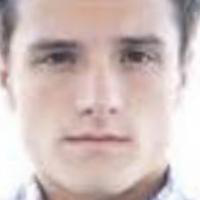

In [8]:
# 0 corresponds to male, 1 corresponds to female.
rand_number = random.randint(0,len(df))
print("Age and Gender : ",df['Ages'][rand_number],", ", get_gender(df['Genders'][rand_number]))
display(df['Images'][rand_number])

In [9]:
df.describe()

,Ages,Genders
count,5000.000000,5000.000000
mean,33.592800,0.474400
std,20.047059,0.499394
min,1.000000,0.000000
25%,23.000000,0.000000
50%,30.000000,0.000000
75%,45.000000,1.000000
max,116.000000,1.000000


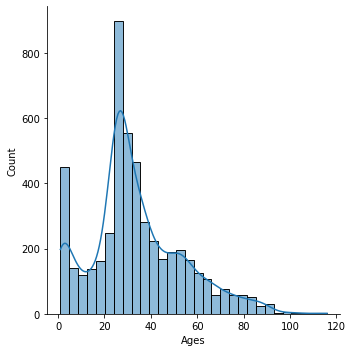

In [10]:
sns.displot(df['Ages'],kde=True, bins=30);

# __Data modification__
Too many faces of people between 0 and 4 years old. The model would fit too well to these ages and not enough to the other ages. On the other hand, there aren't many images of people over 80, which would cause the model to not train well enough on those ages. So it is better to just remove over 80s and only have a model that can predict the ages of people over 4 and under 80.

In [11]:
print("Number of Samples before remove: ", df.shape)
df = df[(df['Ages'] > 4) & (df['Ages'] < 70)]
print("Number of Samples after remove: ", df.shape)

Number of Samples before remove:  (5000, 3)
Number of Samples after remove:  (4240, 3)


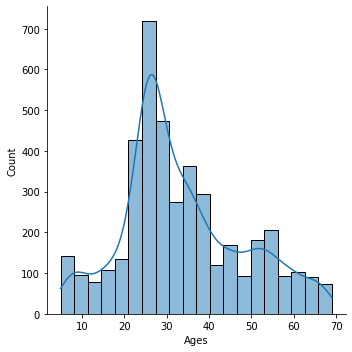

In [25]:
sns.displot(df['Ages'],kde=True, bins=20);

# __Prepare datasets__

In [12]:
X = []
Y = []  # age
Z = []  # gender

def make_X(a):
    b = a.resize((size,size), Image.ANTIALIAS)
    ar = np.asarray(b)
    X.append(ar) 
        
df['Images'].map(make_X)          
X = np.array(X)
Y = np.array(df['Ages'])
Z = np.array(df['Genders'])

print(X.shape)
print(Y.shape)
print(Z.shape)

(4240, 200, 200, 3)
(4240,)
(4240,)


## __Train and Validation data__

In [13]:
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.33)

for train_index, test_index in sss.split(X, Y):
#     print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = Y[train_index], Y[test_index]
  z_train, z_test = Z[train_index], Z[test_index]

print(X_train.shape)
print(y_train.shape)
print(z_train.shape)

(2840, 200, 200, 3)
(2840,)
(2840,)


# Data Augmentation to reduce bias

In [14]:
data_gen_train = ImageDataGenerator(
        rescale=1./255,
        featurewise_center=False,               # set input mean to 0 over the dataset
        samplewise_center=False,                # set each sample mean to 0
        featurewise_std_normalization=False,    # divide inputs by std of the dataset
        samplewise_std_normalization=False,     # divide each input by its std
        zca_whitening=False,                    # apply ZCA whitening
        rotation_range=10,                      # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1,                       # Randomly zoom image 
        width_shift_range=0.1,                  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,                 # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,                  # randomly flip images
        vertical_flip=False)                    # randomly flip images

data_gen_val = ImageDataGenerator(rescale=1./255 ) 

data_gen_train.fit(X_train)
data_gen_val.fit(X_test)

# Define model with Multiple outputs (1: predict age, 2: classify gender)

In [15]:
inputs = Input(shape=(size, size, 3), name='input')

x = Conv2D(32, (3,3), activation='relu', name='C32')(inputs)
x = MaxPooling2D(2,2)(x)

x = Conv2D(64, (3,3), activation='relu', name='C64')(x)
x = MaxPooling2D(2,2)(x)

x = Conv2D(128, (3,3), activation='relu', name='C128')(x)
x = MaxPooling2D(2,2)(x)

x = Conv2D(256, kernel_size=(3, 3), activation='relu') (x)
x = MaxPooling2D(pool_size=(2, 2)) (x)

x = Flatten()(x)
# x = Dense(128, activation='relu', name='D64')(x)

# x = Dense(64, activation='relu', name='D16')(x)
# x = Dropout(0.2)(x)

dense_1 = Dense(256, activation='relu') (x)
dense_2 = Dense(256, activation='relu') (x)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)


age_out    = Dense(1,activation='relu', name='age')(dropout_1)
gender_out = Dense(1, activation='sigmoid', name='gender')(dropout_2)

model = Model(inputs=inputs, outputs=[age_out, gender_out])

model.compile(loss={'age': 'mean_absolute_error','gender': 'binary_crossentropy'},
              optimizer=optimizers.Adam(learning_rate=0.0001),
              metrics={'age': 'mean_absolute_error', 'gender': 'accuracy'})

history = model.fit(X_train, {'age': y_train, 'gender': z_train}, epochs=n_epochs, batch_size= n_batch_size,validation_data=(X_test,{'age': y_test, 'gender': z_test}))


Epoch 1/30
84/84 [==============================] - 254s 3s/step - loss: 18.3810 - age_loss: 16.8341 - gender_loss: 1.5469 - age_mean_absolute_error: 16.8341 - gender_accuracy: 0.6673 - val_loss: 13.0346 - val_age_loss: 12.6270 - val_gender_loss: 0.4076 - val_age_mean_absolute_error: 12.6270 - val_gender_accuracy: 0.8407
Epoch 2/30
84/84 [==============================] - 245s 3s/step - loss: 11.7785 - age_loss: 11.3751 - gender_loss: 0.4034 - age_mean_absolute_error: 11.3751 - gender_accuracy: 0.8292 - val_loss: 10.6465 - val_age_loss: 10.3320 - val_gender_loss: 0.3145 - val_age_mean_absolute_error: 10.3320 - val_gender_accuracy: 0.8686
Epoch 3/30
84/84 [==============================] - 243s 3s/step - loss: 10.7601 - age_loss: 10.4107 - gender_loss: 0.3494 - age_mean_absolute_error: 10.4107 - gender_accuracy: 0.8574 - val_loss: 9.8475 - val_age_loss: 9.5682 - val_gender_loss: 0.2793 - val_age_mean_absolute_error: 9.5682 - val_gender_accuracy: 0.8821
Epoch 4/30
84/84 [================

# Evaluation results

In [16]:
_, age_loss,gender_loss, age_mean_absolute_error,gender_accuracy = model.evaluate(X_train,[y_train,z_train])
print("\nTrain Status:")
print("Age_MAE = ",age_mean_absolute_error)
print("Gender_accuracy = ",gender_accuracy,"\n")

_, age_loss,gender_loss, age_mean_absolute_error,gender_accuracy = model.evaluate(X_test,[y_test,z_test])
print("\nValidation Status:")
print("Age_MAE = ",age_mean_absolute_error)
print("Gender_accuracy = ",gender_accuracy)

89/89 [==============================] - 60s 668ms/step - loss: 3.7976 - age_loss: 3.7892 - gender_loss: 0.0083 - age_mean_absolute_error: 3.7892 - gender_accuracy: 0.9989

Train Status:
Age_MAE =  3.789242744445801
Gender_accuracy =  0.9989436864852905 

44/44 [==============================] - 29s 655ms/step - loss: 8.1801 - age_loss: 7.8565 - gender_loss: 0.3237 - age_mean_absolute_error: 7.8565 - gender_accuracy: 0.9136

Validation Status:
Age_MAE =  7.856460094451904
Gender_accuracy =  0.9135714173316956


# Evaluating one sample data

Actual Age and Gender    :  30 ,  Female
1/1 [==============================] - 0s 45ms/step
Predicted Age and Gender :  29.0 ,  Female


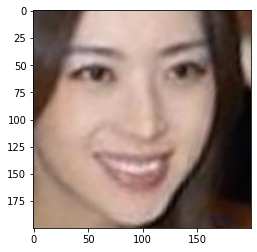

In [22]:
# 0 corresponds to male, 1 corresponds to female.
rand_number = random.randint(0,len(X_test))
img=X_test[rand_number]
plt.imshow(img)
print("Actual Age and Gender    : ",y_test[rand_number],", ", get_gender(z_test[rand_number]))

predicted_age, predicted_gender= model.predict(img.reshape(-1,size,size,3))
print("Predicted Age and Gender : ",np.round(predicted_age)[0][0],", ",get_gender(np.round(predicted_gender)[0][0]))

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
# serialize model to JSON and serialize weights to HDF5

model_json = model.to_json()
with open("/content/drive/MyDrive/Colab Notebooks/Zummit Infolabs/gender detection and age prediction/model.json", "w") as json_file:
    json_file.write(model_json)
    
model.save_weights("/content/drive/MyDrive/Colab Notebooks/Zummit Infolabs/gender detection and age prediction/model.h5")